### Feature preprocessing

#### FinBERT Score

In [83]:
import pandas as pd
import numpy as np

sentiment = pd.read_csv('../../Data/federal_sentiment.csv', index_col = 0)

In [84]:
sentiment.index = pd.to_datetime(sentiment.index).strftime('%Y-%m')
sentiment.fillna(method = 'ffill', inplace = True)
sentiment

,Positive,Negative,Neutral,sentimental_score
Date,,,,
2006-01,7.971052e-08,2.516444e-07,1.000000,0.500000
2006-02,2.134020e-01,4.994306e-01,0.287167,-0.142445
2006-03,2.156177e-01,5.577889e-01,0.226593,-0.228875
2006-04,4.671889e-02,4.433666e-01,0.509914,-0.141691
2006-05,1.709526e-04,6.226610e-01,0.377168,-0.433906
...,...,...,...,...
2023-07,5.476058e-02,6.210716e-01,0.324168,-0.404227
2023-08,5.046593e-04,7.823840e-01,0.217111,-0.673324
2023-09,1.012808e-03,6.145024e-01,0.384485,-0.421247


#### GDP Data

In [85]:
gdp = pd.read_csv('../../Data/GDP.csv',index_col = 0)
gdp.index = pd.to_datetime(gdp.index).strftime('%Y-%m')
gdp

,GDP
DATE,
2004-01,11923.447
2004-04,12112.815
2004-07,12305.307
2004-10,12527.214
2005-01,12767.286
...,...
2022-07,25994.639
2022-10,26408.405
2023-01,26813.601


In [104]:
cpi = pd.read_csv('../../Data/CPIAUCSL.csv',index_col = 0)
cpi.index = pd.to_datetime(cpi.index).strftime('%Y-%m')
cpi

,CPIAUCSL
DATE,
2004-01,186.300
2004-02,186.700
2004-03,187.100
2004-04,187.400
2004-05,188.200
...,...
2023-06,303.841
2023-07,304.348
2023-08,306.269


In [105]:
gdp_rate = np.log(gdp / gdp.shift(4)).dropna()
cpi_rate = np.log(cpi / cpi.shift(12)).dropna()

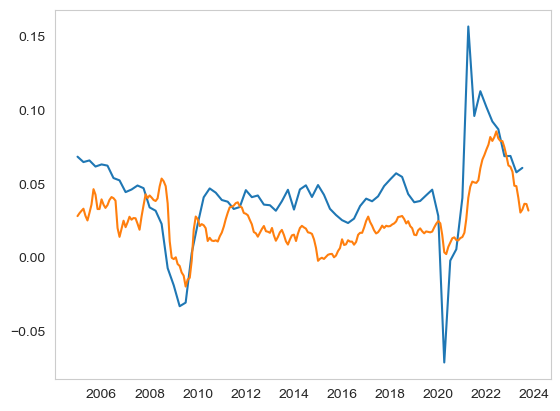

In [25]:
import matplotlib.pyplot as plt
plt.plot(gdp_rate)
plt.plot(cpi_rate)
plt.grid(False)

GDP 결측치 : proportional denton method

In [26]:
from statsmodels.tsa.interp.denton import dentonm

benchmarked = dentonm(cpi_rate.cumsum(), gdp_rate.cumsum(), freq = "qm")

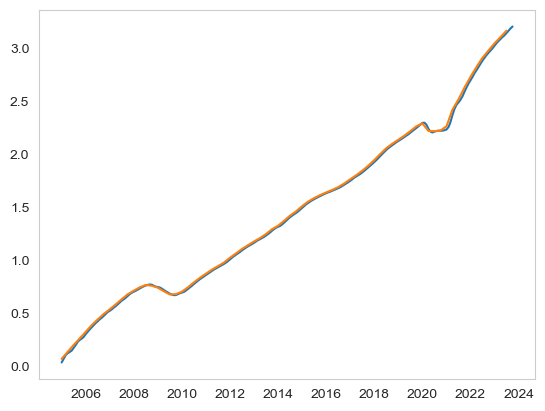

In [29]:
plt.plot(pd.Series(benchmarked * 3, index = cpi_rate.index))
plt.plot(gdp_rate.cumsum())
plt.grid(False)

In [102]:
target_gdp = (pd.Series(benchmarked, index = cpi_rate.index) - pd.Series(benchmarked, index = cpi_rate.index).shift(1)).dropna() * 3
target_gdp.index = target_gdp.index.strftime('%Y-%m')

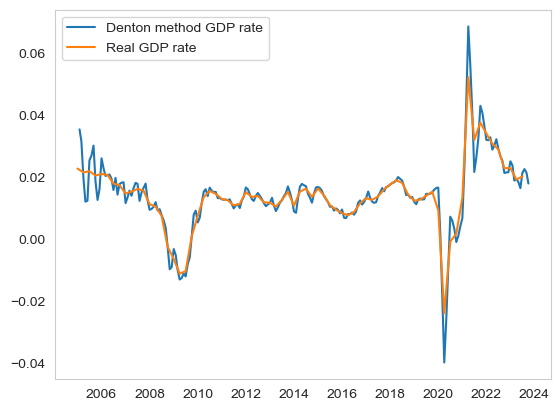

In [52]:
plt.plot(target_gdp, label = 'Denton method GDP rate')
plt.plot(gdp_rate / 3, label = 'Real GDP rate')
plt.legend()
plt.grid(False)
plt.show()

#### Federal Funds Rate

In [100]:
ffr = pd.read_csv('../../Data/DFF.csv', index_col = 0) * 0.01
ffr.index = pd.to_datetime(ffr.index)
ffr = ffr.resample('M').mean()
ffr.index = ffr.index.strftime('%Y-%m')
ffr

,DFF
DATE,
2005-01,0.022794
2005-02,0.025018
2005-03,0.026290
2005-04,0.027850
2005-05,0.030026
...,...
2023-07,0.051200
2023-08,0.053300
2023-09,0.053300


#### Unemployment Rate

In [94]:
unemploy = pd.read_csv('../../Data/UNRATE.csv', index_col = 0) * 0.01
unemploy.index = pd.to_datetime(unemploy.index).strftime('%Y-%m')
unemploy

,UNRATE
DATE,
2005-01,0.053
2005-02,0.054
2005-03,0.052
2005-04,0.052
2005-05,0.051
...,...
2023-06,0.036
2023-07,0.035
2023-08,0.038


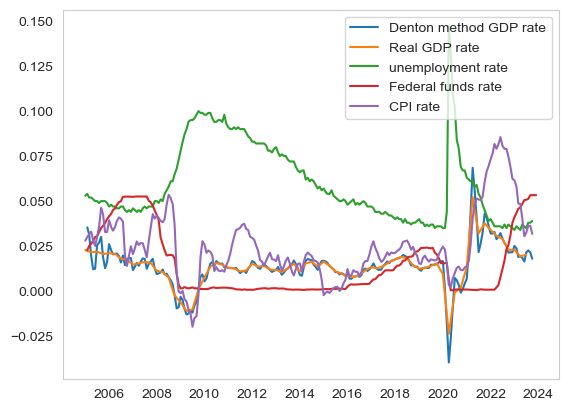

In [80]:
plt.plot(target_gdp, label = 'Denton method GDP rate')
plt.plot(gdp_rate / 3, label = 'Real GDP rate')
plt.plot(unemploy, label = 'unemployment rate')
plt.plot(ffr, label = 'Federal funds rate')
plt.plot(cpi_rate, label = 'CPI rate')
plt.legend()
#(sentiment['sentimental_score'] * 0.1).plot(label = 'federal sentiment score')
plt.grid(False)
plt.show()

In [145]:
feature_matrix = pd.concat(
    [
        sentiment['sentimental_score'],
        ffr,
        cpi_rate,
        unemploy,
        target_gdp
    ],
    axis = 1
)

feature_matrix.columns = ['FED_sentiment','federal_funds_rate','cpi','unemployment_rate','gdp_rate']

In [166]:
feature_matrix.dropna(inplace = True)
feature_matrix.index = pd.to_datetime(feature_matrix.index)

#### RandomForest Regressor

In [190]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [201]:
X = feature_matrix.iloc[:,:-1]
y = feature_matrix['gdp_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, shuffle = False, random_state = 42)

randomforest_reg = RandomForestRegressor(n_estimators = 1000,
                                         random_state = 42,
                                         criterion = 'absolute_error',
                                         ccp_alpha = 0.0001)
randomforest_reg.fit(X_train, y_train)

RandomForestRegressor(ccp_alpha=0.0001, criterion='absolute_error',
                      n_estimators=1000, random_state=42)

In [202]:
from sklearn.metrics import mean_squared_error
y_pred = randomforest_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 5.17486056411542e-06


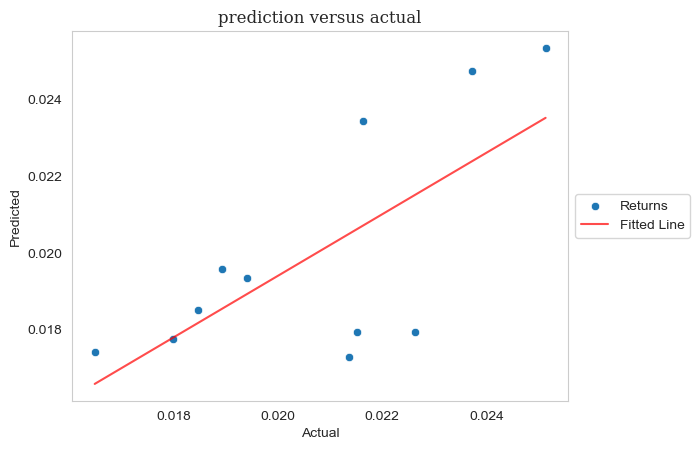

In [203]:
import seaborn as sns

beta, alpha = np.polyfit(x = y_test, y = y_pred , deg = 1)
#plt.axvline(0, color = 'grey', alpha = 0.5)
#plt.axhline(0, color = 'grey', alpha = 0.5)
sns.scatterplot(x = y_test , y = y_pred , label = 'Returns')
sns.lineplot(x = y_test, y = alpha + y_test * beta, color = 'red', label = 'Fitted Line', alpha = 0.7)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.grid(False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('prediction versus actual', fontfamily = 'Serif')
plt.show()

In [204]:
import shap

X = feature_matrix.iloc[:,:-1]
y = feature_matrix['gdp_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, shuffle = False, random_state = 42)

explainer_randomforest_reg = shap.TreeExplainer(randomforest_reg)

shap_values_train = explainer_randomforest_reg(X_train)
shap_values_test = explainer_randomforest_reg(X_test)
shap_values_all = explainer_randomforest_reg(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


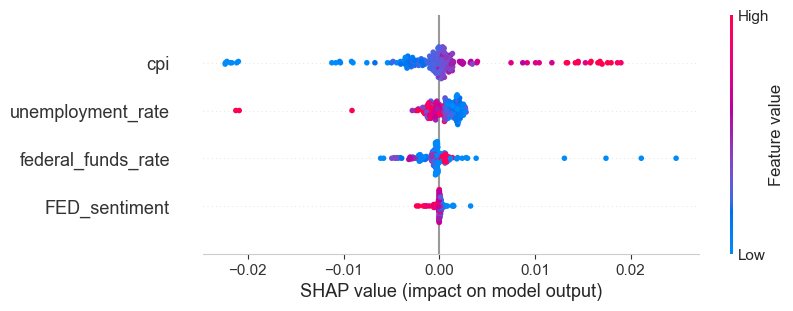

In [205]:
plt.grid(False)
shap.plots.beeswarm(shap_values_train)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


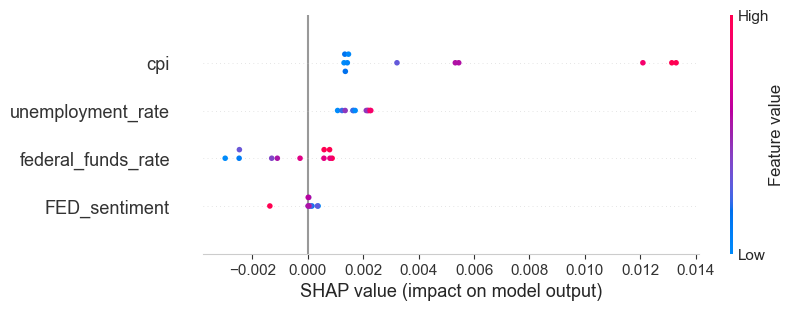

In [206]:
plt.grid(False)
shap.plots.beeswarm(shap_values_test)

Text(0.5, 1.0, 'GDP forecast')

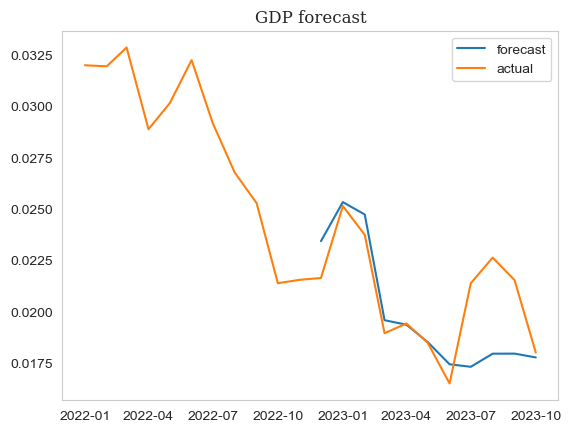

In [208]:
plt.plot(pd.Series(y_pred, index = y_test[-(len(y_pred)):].index), label = 'forecast')
plt.plot(feature_matrix['gdp_rate'].loc['2022':], label = 'actual')
plt.grid(False)
plt.legend()
plt.title('GDP forecast', fontsize = 12, fontfamily = 'Serif')